## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# SyriaTel Customer Churn Classification — Phase 3 Project

**Goal:** Build and evaluate classification models that predict whether a SyriaTel customer will churn, and translate model performance into business recommendations.

**Primary stakeholder:** SyriaTel Customer Retention / Revenue team  
**Business question:** *Which customers are at risk of churning soon so we can intervene early and reduce lost revenue?*

> **Primary metric:** Recall for the churn (positive) class — missing a true churner (false negative) is costly.

In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier

# Set random seed for reproducibility
np.random.seed(42)


## 1. Data Loading

This notebook expects a **CSV** file for the SyriaTel churn dataset.

- If your file is named something like `syria_tel_churn.csv`, place it in the same folder as this notebook and update the path below.
- The target column is expected to be named **`churn`** (case-insensitive works in the helper below).

In [7]:
import zipfile

with zipfile.ZipFile("zippedData/achive.zip") as z:
    print(z.namelist())


['bigml_59c28831336c6604c800002a.csv']


In [9]:
# Load the dataset
with zipfile.ZipFile("zippedData/achive.zip") as z:
    with z.open("bigml_59c28831336c6604c800002a.csv") as f:
        df = pd.read_csv(f)

df.head()


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 2. Business Understanding
The goal is to build a classifier that predicts customer churn for SyriaTel, helping the company retain customers and minimize revenue loss. This is a binary classification problem where the target is 'churn' (True/False)."

We will inspect data shape, types, missing values, and churn class balance.

In [16]:
# Basic info
print("Shape:", df.shape) # Rows and columns

Shape: (3333, 21)


In [13]:
print(df.info()) # Data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [14]:
df.describe(include="all").T.head(20) # Summary stats

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
state,3333,51,WV,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account length,3333.0,NaN,NaN,NaN,101.064806,39.822106,1.0,74.0,101.0,127.0,243.0
area code,3333.0,NaN,NaN,NaN,437.182418,42.37129,408.0,408.0,415.0,510.0,510.0
phone number,3333,3333,382-4657,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
international plan,3333,2,no,3010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voice mail plan,3333,2,no,2411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number vmail messages,3333.0,NaN,NaN,NaN,8.09901,13.688365,0.0,0.0,0.0,20.0,51.0
total day minutes,3333.0,NaN,NaN,NaN,179.775098,54.467389,0.0,143.7,179.4,216.4,350.8
total day calls,3333.0,NaN,NaN,NaN,100.435644,20.069084,0.0,87.0,101.0,114.0,165.0
total day charge,3333.0,NaN,NaN,NaN,30.562307,9.259435,0.0,24.43,30.5,36.79,59.64


In [21]:
# Check churn distribution (class balance)
y_raw = df[target_col]
print(y_raw.value_counts(dropna=False))
print("\nClass proportions:\n", y_raw.value_counts(normalize=True, dropna=False))

churn
False    2850
True      483
Name: count, dtype: int64

Class proportions:
 churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64


#### Notes on Class Imbalance

If churners are a minority class, accuracy can be misleading. We prioritize **recall** for churn to reduce missed churners, while monitoring precision to control unnecessary retention outreach.

## 3. Exploratory Data Analysis (EDA)

Keep EDA focused: a few key relationships relevant to churn.

Below are some common churn drivers in telecom datasets:
- Customer service calls
- International plan / voicemail plan
- Usage minutes and charges

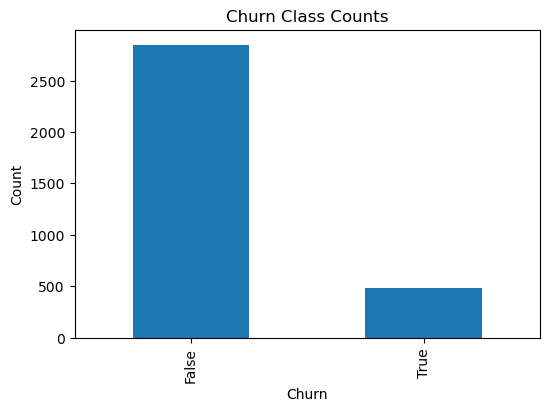

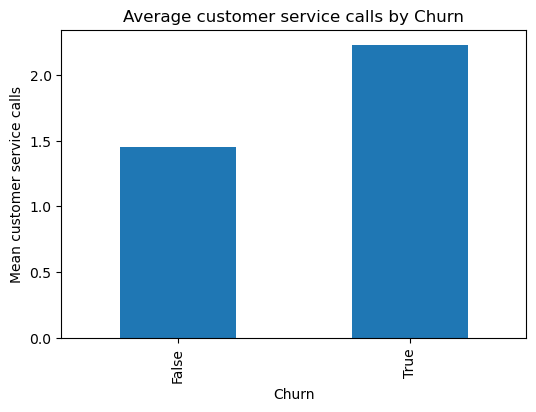

churn,False,True
international plan,,
no,0.885050,0.114950
yes,0.575851,0.424149


churn,False,True
voice mail plan,,
no,0.832849,0.167151
yes,0.913232,0.086768


In [23]:
# Simple EDA plots if columns exist
fig, ax = plt.subplots(figsize=(6,4))
df[target_col].value_counts().plot(kind="bar", ax=ax)
ax.set_title("Churn Class Counts")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
plt.show()

if cs_calls_col is not None:
    fig, ax = plt.subplots(figsize=(6,4))
    df.groupby(target_col)[cs_calls_col].mean().plot(kind="bar", ax=ax)
    ax.set_title(f"Average {cs_calls_col} by Churn")
    ax.set_xlabel("Churn")
    ax.set_ylabel(f"Mean {cs_calls_col}")
    plt.show()

if intl_plan_col is not None:
    ct = pd.crosstab(df[intl_plan_col], df[target_col], normalize="index")
    display(ct)

if vmail_plan_col is not None:
    ct = pd.crosstab(df[vmail_plan_col], df[target_col], normalize="index")
    display(ct)

## 4. Data Preparation

### Preventing Data Leakage
We will:
1. Split into train/test **before** any fitting of scalers/encoders.
2. Use a **Pipeline + ColumnTransformer** so preprocessing is learned only from the training set and applied consistently to test data.

In [28]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# If churn is strings like 'True'/'False' or 'yes'/'no', convert to 0/1
if y.dtype == "object":
    y_str = y.astype(str).str.strip().str.lower()
    # common mappings
    mapping = {
        "true": 1, "false": 0,
        "yes": 1, "no": 0,
        "1": 1, "0": 0,
        "churn": 1, "not churn": 0
    }
    if set(y_str.unique()).issubset(set(mapping.keys())):
        y = y_str.map(mapping).astype(int)
    else:
        # If values are like 'Yes'/'No' etc, try a fallback:
        # treat the most common "non-churn" token as 0 and the other as 1
        uniq = y_str.unique()
        if len(uniq) == 2:
            y = (y_str == uniq[0]).astype(int)  # may invert; we'll check below
        else:
            raise ValueError(f"Target has unexpected string categories: {uniq}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())

Train shape: (2499, 20) Test shape: (834, 20)
Train churn rate: 0.1448579431772709 Test churn rate: 0.145083932853717


In [29]:
# Identify numeric vs categorical columns
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

numeric_features[:10], categorical_features[:10], len(numeric_features), len(categorical_features)

(['account length',
  'area code',
  'number vmail messages',
  'total day minutes',
  'total day calls',
  'total day charge',
  'total eve minutes',
  'total eve calls',
  'total eve charge',
  'total night minutes'],
 ['state', 'phone number', 'international plan', 'voice mail plan'],
 16,
 4)

In [35]:

# Preprocessing for numeric data: impute missing values + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessing for categorical data: impute + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

## 5. Modeling — Baseline Model (Interpretable)

### Baseline: Logistic Regression
Logistic regression is a strong baseline for binary classification and offers interpretability (directional effects via coefficients).

Baseline Logistic Regression (TEST)
Recall (churn=1):   0.248
Precision (churn=1):0.577
F1 (churn=1):       0.347
ROC-AUC:            0.799

Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.97      0.92       713
        True       0.58      0.25      0.35       121

    accuracy                           0.86       834
   macro avg       0.73      0.61      0.64       834
weighted avg       0.84      0.86      0.84       834



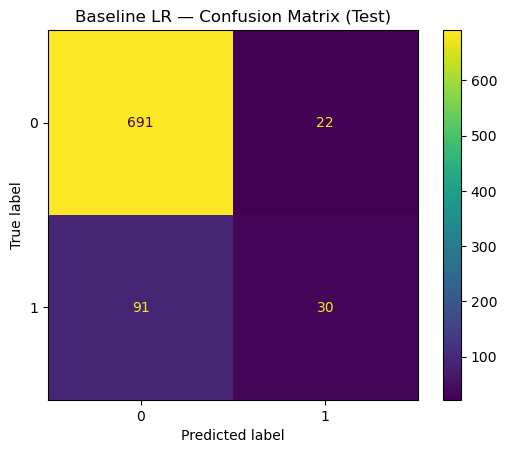

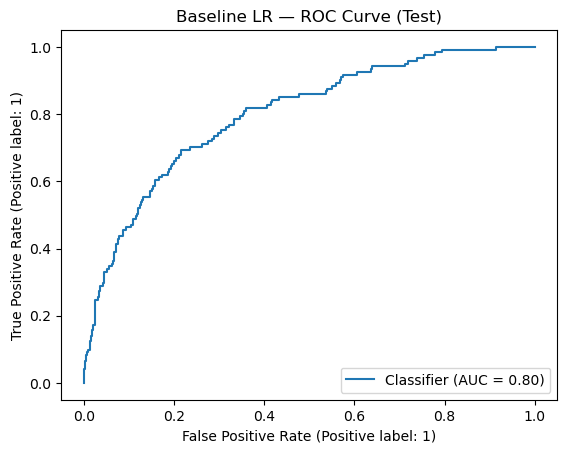

In [39]:
baseline_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

baseline_lr.fit(X_train, y_train)

y_pred = baseline_lr.predict(X_test)
y_proba = baseline_lr.predict_proba(X_test)[:, 1]

# Primary metric: recall on churn class (assumes churn=1)
rec = recall_score(y_test, y_pred, pos_label=1)
prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

# ROC-AUC can fail if probabilities are constant; handle safely.
try:
    auc = roc_auc_score(y_test, y_proba)
except Exception:
    auc = np.nan

print("Baseline Logistic Regression (TEST)")
print(f"Recall (churn=1):   {rec:.3f}")
print(f"Precision (churn=1):{prec:.3f}")
print(f"F1 (churn=1):       {f1:.3f}")
print(f"ROC-AUC:            {auc:.3f}" if not np.isnan(auc) else "ROC-AUC:            NA")

print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Baseline LR — Confusion Matrix (Test)")
plt.show()

if not np.isnan(auc):
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("Baseline LR — ROC Curve (Test)")
    plt.show()

## 6. Model Iteration — Tuned Logistic Regression

We tune hyperparameters to improve performance, especially churn recall.  
Common tuning lever: **regularization strength `C`**.

Best params: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV recall: 0.22077625570776252

Tuned Logistic Regression (TEST)
Recall (churn=1):   0.264
Precision (churn=1):0.582
F1 (churn=1):       0.364
ROC-AUC:            0.794


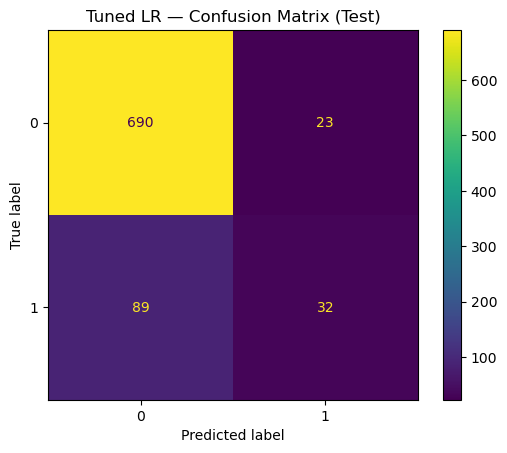

In [40]:
tuned_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1.0, 3.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    tuned_lr,
    param_grid=param_grid_lr,
    scoring="recall",   # focus on recall for churn
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best params:", grid_lr.best_params_)
print("Best CV recall:", grid_lr.best_score_)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

rec_lr = recall_score(y_test, y_pred_lr, pos_label=1)
prec_lr = precision_score(y_test, y_pred_lr, pos_label=1, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, pos_label=1, zero_division=0)

try:
    auc_lr = roc_auc_score(y_test, y_proba_lr)
except Exception:
    auc_lr = np.nan

print("\nTuned Logistic Regression (TEST)")
print(f"Recall (churn=1):   {rec_lr:.3f}")
print(f"Precision (churn=1):{prec_lr:.3f}")
print(f"F1 (churn=1):       {f1_lr:.3f}")
print(f"ROC-AUC:            {auc_lr:.3f}" if not np.isnan(auc_lr) else "ROC-AUC:            NA")

cm = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Tuned LR — Confusion Matrix (Test)")
plt.show()

## 7. Nonparametric Model — Decision Tree (Tuned)

To satisfy the **nonparametric model** requirement, we build and tune a decision tree.  
Decision trees can capture nonlinear relationships and interactions but may overfit without constraints.

Best params: {'model__max_depth': 8, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20}
Best CV recall: 0.7542998477929984

Tuned Decision Tree (TEST)
Recall (churn=1):   0.645
Precision (churn=1):0.876
F1 (churn=1):       0.743


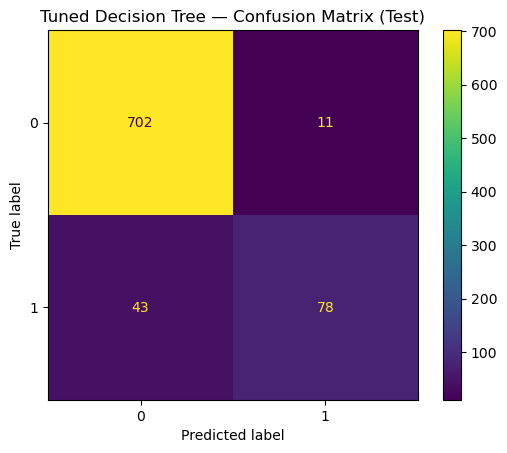

In [44]:
tree_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier())
])

param_grid_tree = {
    "model__max_depth": [2, 3, 4, 5, 8, None],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10]
}

grid_tree = GridSearchCV(
    tree_pipe,
    param_grid=param_grid_tree,
    scoring="recall",
    cv=5,
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

print("Best params:", grid_tree.best_params_)
print("Best CV recall:", grid_tree.best_score_)

best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)

rec_tree = recall_score(y_test, y_pred_tree, pos_label=1)
prec_tree = precision_score(y_test, y_pred_tree, pos_label=1, zero_division=0)
f1_tree = f1_score(y_test, y_pred_tree, pos_label=1, zero_division=0)

print("\nTuned Decision Tree (TEST)")
print(f"Recall (churn=1):   {rec_tree:.3f}")
print(f"Precision (churn=1):{prec_tree:.3f}")
print(f"F1 (churn=1):       {f1_tree:.3f}")

cm = confusion_matrix(y_test, y_pred_tree)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Tuned Decision Tree — Confusion Matrix (Test)")
plt.show()

## 8. Model Comparison

We compare test performance across models, prioritizing **churn recall** while monitoring precision and F1.

In [45]:
results = pd.DataFrame([
    {"model": "Baseline Logistic Regression", "recall": rec, "precision": prec, "f1": f1, "roc_auc": auc},
    {"model": "Tuned Logistic Regression", "recall": rec_lr, "precision": prec_lr, "f1": f1_lr, "roc_auc": auc_lr},
    {"model": "Tuned Decision Tree", "recall": rec_tree, "precision": prec_tree, "f1": f1_tree, "roc_auc": np.nan},
]).sort_values(by="recall", ascending=False)

results

,model,recall,precision,f1,roc_auc
2,Tuned Decision Tree,0.644628,0.876404,0.742857,NaN
1,Tuned Logistic Regression,0.264463,0.581818,0.363636,0.793597
0,Baseline Logistic Regression,0.247934,0.576923,0.346821,0.799149


## 9. Feature Importance / Drivers of Churn (Interpretability)

For logistic regression, we can inspect coefficients to understand which factors are associated with churn risk.

In [46]:
# Extract feature names after preprocessing
ohe = best_lr.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"] if "cat" in best_lr.named_steps["preprocess"].named_transformers_ else None

num_names = numeric_features
cat_names = []
if ohe is not None and len(categorical_features) > 0:
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()

feature_names = num_names + cat_names

# Extract coefficients
coef = best_lr.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(15)

,feature,coefficient,abs_coef
1728,phone number_391-2159,5.534147,5.534147
1056,phone number_364-5510,5.319483,5.319483
2039,phone number_402-6744,5.178537,5.178537
710,phone number_351-7005,4.968901,4.968901
2256,phone number_410-3159,4.950585,4.950585
1938,phone number_399-3083,4.727593,4.727593
397,phone number_340-1876,4.685910,4.685910
216,phone number_333-4594,4.659713,4.659713
1750,phone number_392-2555,4.649748,4.649748
1842,phone number_395-6195,4.583759,4.583759
